In [2]:
%run 01_LLMs_konfigurieren.ipynb

/opt/anaconda3/envs/masterthesis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%run 02_Daten_laden.ipynb

In [4]:
# Bilde ein Subset mit 1.000 Einträgen
sst2_subset = sst2_combined[:1000]
sst2_subset.head()

,index,sentence,label
0,0,hide new secretions from the parental units,0
1,1,"contains no wit , only labored gags",0
2,2,that loves its characters and communicates som...,1
3,3,remains utterly satisfied to remain the same t...,0
4,4,on the worst revenge-of-the-nerds clichés the ...,0


In [5]:
sb10k_subset = sb10k_combined[:1000]
sb10k_subset.head()

,index,Text,Sentiment,sentiment_coded
0,0,RT @TheKedosZone : So ein Hearthstone - Key vo...,positive,1
1,1,"Tainted Talents ( Ateliertagebuch. ) "" Wir sin...",neutral,2
2,2,Aber wenigstens kommt #Supernatural heute mal ...,neutral,2
3,3,DARLEHEN - Angebot für Schufa - freie Darlehen...,neutral,2
4,4,ANRUF ERWÜNSCHT : Hardcore Teeny Vicky Carrera...,neutral,2


In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

# One Shot Prompt

## OpenAI / GPT

In [6]:
openai_client

### SST2

In [7]:
# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gpt_df = pd.DataFrame(columns=['index', 'sentence', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Schleife mit API-Call
for index, row in sst2_subset.iterrows():
    text = row['sentence']
    #print(text)

    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = openai_client.chat.completions.create(
            model="gpt-4o-mini", # gpt-3.5-turbo # gpt-4o-mini
            messages=[
                {
                "role": "user",
                 "content": (f"Klassifiziere den folgenden Text in einen von diesen zwei Sentiments ['negativ', 'positiv']: {text}. Setze 0 für negativ und 1 für positiv. Gebe nur 0 oder 1 zurück ohne zusätzlichen Text.")
                }
            ],
            temperature = 0.2
        )
        response_content = response.choices[0].message.content
        print(index, " ", response_content)        
        

        # Ergebnis in das DataFrame effizient speichern
        results_gpt_df.loc[row_counter] = [index, text, response_content]
        row_counter += 1

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.strip()

# Behalte nur die Zeilen mit generierten Labels, die entweder 0 oder 1 sind
results_gpt_df_final = results_gpt_df[results_gpt_df['generated_label'].isin(['0', '1'])]

# als int formatieren
results_gpt_df_final['generated_label'] = results_gpt_df_final['generated_label'].astype(int)


# CSV abspeichern 
results_gpt_df_final.to_csv('SC_SST2_BASELINE_GPT.csv')

0   0
1   0
2   1
3   1
4   0
5   0
6   1
7   0
8   0
9   1
10   0
11   0
12   0
13   0
14   0
15   1
16   0
17   1
18   0
19   1
20   1
21   1
22   1
23   1
24   0
25   1
26   0
27   1
28   1
29   0
30   0
31   1
32   0
33   0
34   0
35   1
36   1
37   1
38   0
39   0
40   0
41   0
42   0
43   1
44   0
45   1
46   1
47   0
48   1
49   0
50   0
51   1
52   0
53   1
54   0
55   0
56   0
57   1
58   0
59   0
60   1
61   0
62   0
63   0
64   0
65   1
66   0
67   0
68   0
69   1
70   0
71   0
72   1
73   0
74   0
75   1
76   0
77   0
78   0
79   1
80   1
81   Bitte geben Sie den Text ein, den Sie klassifiziert haben möchten.
82   1
83   1
84   1
85   0
86   1
87   1
88   1
89   1
90   0
91   1
92   1
93   1
94   1
95   1
96   0
97   1
98   1
99   1
100   0
101   1
102   0
103   0
104   0
105   1
106   0
107   0
108   1
109   0
110   0
111   1
112   1
113   1
114   0
115   0
116   0
117   0
118   1
119   0
120   1
121   0
122   0
123   0
124   0
125   0
126   1
127   1
128   1
129   0
130  

ValueError: invalid literal for int() with base 10: 'Bitte geben Sie den Text ein, den Sie klassifiziert haben möchten.'

### Evaluation

In [18]:

# Annahme: Beide DataFrames haben eine Spalte 'index' als gemeinsamen Schlüssel
# results_gpt_df: enthält die von LLM generierten Sentiment-Labels
# sst2_subset: enthält die tatsächlichen (gold standard) Sentiment-Labels

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(sst2_subset, results_gpt_df_final, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['label']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der positiven Klassifikation)
precision = precision_score(true_labels, predicted_labels, pos_label=1)
print(f'Precision: {precision:.2f}')

# 3. Recall (Empfindlichkeit, Trefferquote)
recall = recall_score(true_labels, predicted_labels, pos_label=1)
print(f'Recall: {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall)
f1 = f1_score(true_labels, predicted_labels, pos_label=1)
print(f'F1-Score: {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0,1])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.91
Precision: 0.97
Recall: 0.86
F1-Score: 0.91
Confusion Matrix:
[[442  15]
 [ 76 464]]


### SB10k

In [19]:
# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gpt_sb10k_df = pd.DataFrame(columns=['index', 'sentence', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Schleife mit API-Call
for index, row in sb10k_subset.iterrows():
    text = row['Text']
    #print(text)

    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = openai_client.chat.completions.create(
            model="gpt-4o-mini", # gpt-3.5-turbo # gpt-4o-mini
            messages=[
                {
                "role": "user",
                 "content": (f"Klassifiziere den folgenden Text in einen von diesen drei Sentiments ['negativ', 'positiv', 'neutral']: {text}. Setze 0 für negativ, 1 für positiv und 2 für Neutral. Gebe nur 0, 1 oder 2 zurück ohne zusätzlichen Text.")
                }
            ],
            temperature = 0.2
        )
        response_content = response.choices[0].message.content
        print(index, " ", response_content)        
        

        # Ergebnis in das DataFrame effizient speichern
        results_gpt_sb10k_df.loc[row_counter] = [index, text, response_content]
        row_counter += 1

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gpt_sb10k_df['generated_label'] = results_gpt_sb10k_df['generated_label'].str.strip()

# Behalte nur die Zeilen mit generierten Labels, die entweder 0 oder 1 sind
results_gpt_sb10k_df_final = results_gpt_sb10k_df[results_gpt_sb10k_df['generated_label'].isin(['0', '1','2',0,1,2])]

# als int formatieren
results_gpt_sb10k_df_final['generated_label'] = results_gpt_sb10k_df_final['generated_label'].astype(int)

# CSV abspeichern 
results_gpt_sb10k_df_final.to_csv('SC_SB10k_BASELINE_GPT.csv')





0   1
1   2
2   0
3   2
4   2
5   2
6   1
7   0
8   2
9   1
10   1
11   2
12   2
13   1
14   1
15   0
16   0
17   2
18   0
19   1
20   0
21   2
22   1
23   1
24   2
25   2
26   2
27   2
28   0
29   2
30   2
31   0
32   0
33   1
34   2
35   2
36   0
37   2
38   2
39   2
40   0
41   2
42   0
43   2
44   1
45   1
46   2
47   1
48   1
49   0
50   1
51   0
52   1
53   0
54   0
55   0
56   1
57   1
58   0
59   2
60   2
61   1
62   2
63   2
64   1
65   2
66   1
67   1
68   2
69   2
70   2
71   2
72   0
73   1
74   0
75   1
76   1
77   1
78   1
79   2
80   1
81   2
82   1
83   0
84   2
85   1
86   0
87   2
88   0
89   1
90   2
91   1
92   2
93   0
94   1
95   2
96   2
97   0
98   0
99   2
100   1
101   2
102   1
103   2
104   2
105   2
106   1
107   2
108   2
109   1
110   2
111   2
112   2
113   2
114   0
115   1
116   2
117   1
118   0
119   2
120   1
121   0
122   1
123   0
124   2
125   0
126   2
127   2
128   0
129   0
130   1
131   2
132   1
133   0
134   2
135   1
136   1
137   1
138   

#### Evaluation

In [26]:

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(sb10k_subset, results_gpt_sb10k_df_final, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['sentiment_coded']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der Klassifikation für alle Klassen)
precision = precision_score(true_labels, predicted_labels, average='macro')
print(f'Precision (macro): {precision:.2f}')

# 3. Recall (Empfindlichkeit für alle Klassen)
recall = recall_score(true_labels, predicted_labels, average='macro')
print(f'Recall (macro): {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall für alle Klassen)
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f'F1-Score (macro): {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.62
Precision (macro): 0.61
Recall (macro): 0.70
F1-Score (macro): 0.61
Confusion Matrix:
[[140   5  16]
 [ 24 168  42]
 [178 115 312]]


Matplotlib is building the font cache; this may take a moment.


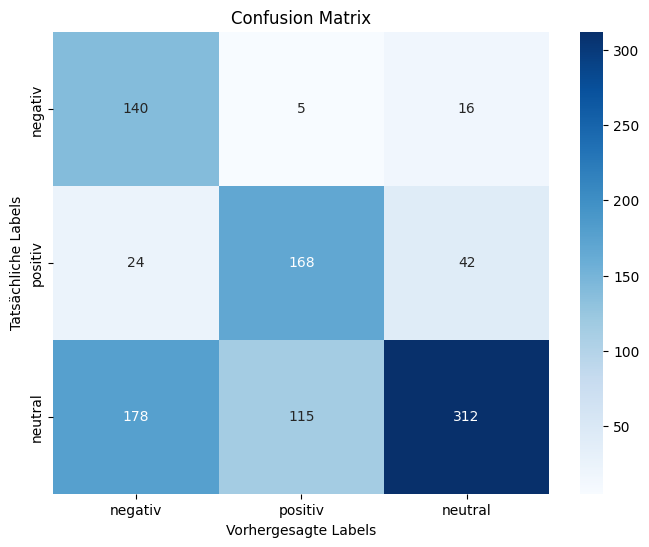

In [27]:
# Confusion Matrix berechnen (true_labels und predicted_labels sind die tatsächlichen und vorhergesagten Labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Klassenlabels definieren
class_names = ['negativ', 'positiv', 'neutral']

# Confusion Matrix als Heatmap darstellen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Achsen beschriften
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Tatsächliche Labels')
plt.title('Confusion Matrix')

# Plot anzeigen
plt.show()

## Gemini

In [19]:
genai_model

genai.GenerativeModel(
    model_name='models/gemini-1.5-flash-001',
    generation_config={},
    safety_settings={},
    tools=None,
    system_instruction=None,
    cached_content=None
)

### SST2

In [20]:
# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gemini_df = pd.DataFrame(columns=['index', 'sentence', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Schleife mit API-Call
for index, row in sst2_subset.iterrows():
    text = row['sentence']

    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = genai_model.generate_content(f"Klassifiziere den folgenden Text in einen von diesen zwei Sentiments ['negativ', 'positiv']: {text}. Setze 0 für negativ und 1 für positiv. Gebe nur 0 oder 1 zurück ohne zusätzlichen Text.")
        print(index, " ", response.text)

        # Ergebnis in das DataFrame effizient speichern
        results_gemini_df.loc[row_counter] = [index, text, response.text]
        row_counter += 1

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.strip()

# Behalte nur die Zeilen mit generierten Labels, die entweder 0 oder 1 sind
results_gemini_df_final = results_gemini_df[results_gemini_df['generated_label'].isin(['0', '1',0,1])]

# als int formatieren
results_gemini_df_final['generated_label'] = results_gemini_df_final['generated_label'].astype(int)


# CSV abspeichern 
results_gemini_df_final.to_csv('SC_SST2_BASELINE_GEMINI.csv')


0   0 

1   0 

2   1

3   0 

4   0 

5   0 

6   1 

7   0 

8   0 

9   1

10   0 

11   0 

12   0 

13   0 

14   0 

15   1 

16   0 

17   1

18   0 

19   1 

20   1

21   0 

22   1 

23   1

24   0 

25   1 

26   0 

27   0 

28   1 

29   0 

30   0 

31   1

32   0 

33   0 

34   0 

35   1

36   0 

37   1 

38   0 

39   0 

40   0 

41   0 

42   0 

43   1

44   0 

45   1

46   0 

47   0 

48   1 

49   0 

50   0 

51   0 

52   0 

53   1 

54   0 

55   0 

56   0 

57   1

58   1

59   0 

60   1

61   0 

62   0 

63   0 

64   0 

65   1 

66   0 

67   0 

68   0 

69   1

70   0 

71   0 

72   1 

73   0 

74   0 

75   1

76   0 

77   0 

78   0 

79   1

80   1

81   Bitte gib mir den Text, den du klassifizieren möchtest. Ich kann dir dann sagen, ob er negativ oder positiv ist. 

82   0 

83   1

84   1

85   0 

86   1

87   1

88   1 

89   1 

90   0 

91   1

92   0 

93   1 

94   1 

95   0 

96   0 

97   1 

98   1

99   1

100   0 

101   1 

10

#### Evaluation

In [45]:

# Annahme: Beide DataFrames haben eine Spalte 'index' als gemeinsamen Schlüssel
# results_gpt_df: enthält die von LLM generierten Sentiment-Labels
# sst2_subset: enthält die tatsächlichen (gold standard) Sentiment-Labels

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(sst2_subset, results_gemini_df_final, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['label']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der positiven Klassifikation)
precision = precision_score(true_labels, predicted_labels, pos_label=1)
print(f'Precision: {precision:.2f}')

# 3. Recall (Empfindlichkeit, Trefferquote)
recall = recall_score(true_labels, predicted_labels, pos_label=1)
print(f'Recall: {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall)
f1 = f1_score(true_labels, predicted_labels, pos_label=1)
print(f'F1-Score: {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0,1])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.85
Precision: 0.99
Recall: 0.72
F1-Score: 0.84
Confusion Matrix:
[[452   3]
 [147 387]]


### SB10k

In [20]:
sb10k_subset

,index,Text,Sentiment,sentiment_coded
0,0,RT @TheKedosZone : So ein Hearthstone - Key vo...,positive,1
1,1,"Tainted Talents ( Ateliertagebuch. ) "" Wir sin...",neutral,2
2,2,Aber wenigstens kommt #Supernatural heute mal ...,neutral,2
3,3,DARLEHEN - Angebot für Schufa - freie Darlehen...,neutral,2
4,4,ANRUF ERWÜNSCHT : Hardcore Teeny Vicky Carrera...,neutral,2
...,...,...,...,...
995,995,@sinkingFX Die Liebe unter Verwandten . : ' 3,positive,1
996,996,Cros Kindermusik braucht keiner .,negative,0
997,997,RT @ZDFsport : Extrem viele Braunschweiger hie...,positive,1
998,998,Moin Moin ... trotz Regen wünsche ich euch ein...,positive,1


In [28]:
# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_sb10k_gemini_df = pd.DataFrame(columns=['index', 'sentence', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Schleife mit API-Call
for index, row in sb10k_subset.iterrows():
    text = row['Text']

    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = genai_model.generate_content(f"Klassifiziere den folgenden Text in einen von diesen drei Sentiments ['negativ', 'positiv', 'neutral']: {text}. Setze 0 für negativ, 1 für positiv und 2 für Neutral. Gebe nur 0, 1 oder 2 zurück ohne zusätzlichen Text.")
        print(index, " ", response.text)

        # Ergebnis in das DataFrame effizient speichern
        results_sb10k_gemini_df.loc[row_counter] = [index, text, response.text]
        row_counter += 1

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_sb10k_gemini_df['generated_label'] = results_sb10k_gemini_df['generated_label'].str.strip()

# Behalte nur die Zeilen mit generierten Labels, die entweder 0 oder 1 sind
results_gemini_df_final = results_sb10k_gemini_df[results_sb10k_gemini_df['generated_label'].isin(['0', '1','2',0,1,2])]

# als int formatieren
results_gemini_df_final['generated_label'] = results_gemini_df_final['generated_label'].astype(int)


# CSV abspeichern 
results_gemini_df_final.to_csv('SC_SB10k_BASELINE_GEMINI.csv')


0   1 

1   2 

2   0 

3   2 

4   0 

5   2 

6   1 

7   0 

8   2 

9   1 

10   1 

11   2 

12   2 

13   2 

14   1

15   0 

16   0 

17   2

18   0 

19   1 

20   0 

21   2

22   1 

23   1 

24   2 

25   2 

26   2 

27   0 

28   0 

29   2 

30   2 

31   0 

32   0 

33   1 

34   2

35   2 

36   0 

37   0 

38   2 

39   0 

40   0 

41   2 

42   0 

43   2 

44   1 

45   1 

46   0 

47   1 

48   0 

49   0 

50   1

51   0 

52   1 

53   0 

54   0 

55   0 

56   1 

57   1 

58   0 

59   2 

60   2 

61   2 

62   0 

63   2 

64   2 

65   2 

66   1 

67   1

68   1 

69   2

70   0 

71   2 

72   0 

73   1 

74   0 

75   1 

76   1

77   0 

78   2 

79   0 

80   1 

81   2 

82   1 

83   0 

84   2

85   1 

86   0 

87   2 

88   0 

89   1 

90   2 

91   1 

92   2 

93   0 

94   1 

95   1 

96   2 

97   0 

98   0 

99   2 

100   1 

101   0 

102   1 

103   0 

104   2 

105   0 

106   0 

107   2 

108   2 

109   1 

110   2 

111   2 


#### Evaluation

In [29]:

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(sb10k_subset, results_gemini_df_final, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['sentiment_coded']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der Klassifikation für alle Klassen)
precision = precision_score(true_labels, predicted_labels, average='macro')
print(f'Precision (macro): {precision:.2f}')

# 3. Recall (Empfindlichkeit für alle Klassen)
recall = recall_score(true_labels, predicted_labels, average='macro')
print(f'Recall (macro): {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall für alle Klassen)
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f'F1-Score (macro): {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.52
Precision (macro): 0.57
Recall (macro): 0.65
F1-Score (macro): 0.53
Confusion Matrix:
[[151   2   8]
 [ 45 152  37]
 [260 123 221]]


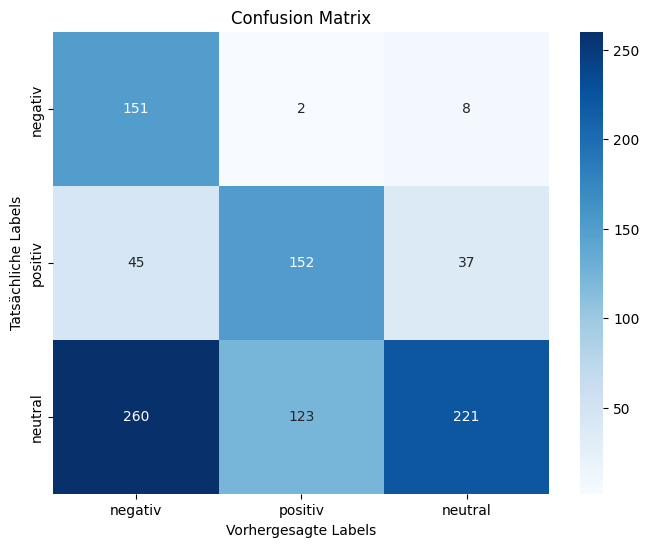

In [30]:
# Confusion Matrix berechnen (true_labels und predicted_labels sind die tatsächlichen und vorhergesagten Labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Klassenlabels definieren
class_names = ['negativ', 'positiv', 'neutral']

# Confusion Matrix als Heatmap darstellen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Achsen beschriften
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Tatsächliche Labels')
plt.title('Confusion Matrix')

# Plot anzeigen
plt.show()